In [1]:
# 18/02/2022 Luís

# In this notebook I'm plotting many curves while varying different parameters of the HGO model. This will be done
# both for uniaxial and equibiaxial loads.

# The goal is to understand better each parameter and their effects on the curves.

# It will also allow me to better set the minimum and maximum values for 
# each of the parameters when generating data for the Machine Learning model.

# Will write some conclusions in the end of each analysis

In [2]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def HGO(params, stretch, load):
    #returns cauchy stress at yy direction if load == "uniaxial"
    #returns cauchy stress at xx and yy directions if load == "equibiaxial"
    
    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    if load == "uniaxial":
        # Deformation Gradient assuming incompressibility and a uniaxial load
        F = sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
        
    if load == "equibiaxial":
        # Deformation Gradient assuming incompressibility and a equibiaxial load
        F = sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
        
    Ft=sym.transpose(F)
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values according to F: 'Cmv'
    Cmv=Fmt*Fm

    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    a01_1 = params[4][0]
    a01_2 = params[4][1]
    a01_3 = params[4][2]
    a01 = sym.Matrix([a01_1, a01_2, a01_3])
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cmv[0,0]), (Cm12, Cmv[0,1]), 
                                  (Cm13, Cmv[0,2]),(Cm21, Cmv[1,0]), 
                                  (Cm22, Cmv[1,1]), (Cm23, Cmv[1,2]),
                                  (Cm31, Cmv[2,0]), (Cm32, Cmv[2,1]), 
                                  (Cm33, Cmv[2,2]),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    if load == 'uniaxial':
        return stretch, T[1,1]

    if load == 'equibiaxial':
        return stretch, [T[0,0],T[1,1]]

def get_curve(params, stretch_min, stretch_max, ninc, load):
    #stores HGO loading runs between a minimum and a maximum stretch
    
    if load == "uniaxial":
        lst=[HGO(params, stretch, load) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
        return lst
    if load == "equibiaxial":
        lst_xx=[[stretch,HGO(params, stretch, load)[1][0]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
        lst_yy=[[stretch,HGO(params, stretch, load)[1][1]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
        return lst_xx, lst_yy

# Studying angle theta

We will begin by studying the effects of the angle theta, the angle between the mean orientation of the fibers and the yy axis.
We will do so by keeping the other parameters unitary and setting the dispersion κ as 0.1. I chose the values 0°; 30°; 45°; 60° and 90°.

### Uniaxial

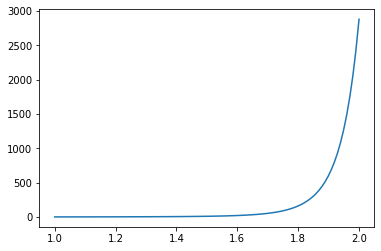

In [4]:
load = "uniaxial"

c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0

theta = 0 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

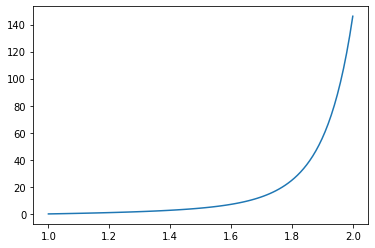

In [5]:
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

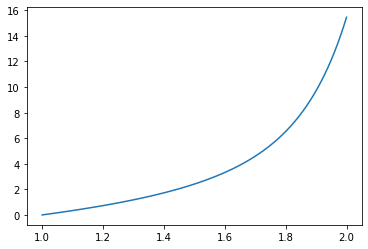

In [6]:
theta = 45 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

A discontinuity apeears for angles between 56° and 67° for these values of stretch.

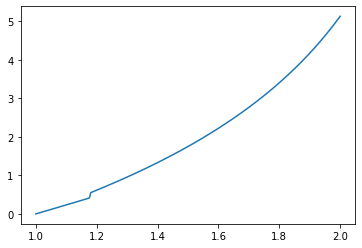

In [7]:
theta = 58 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,200,load))
plt.plot(check[:,0],check[:,1])

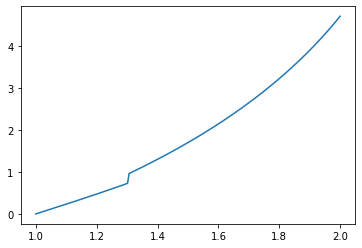

In [8]:
theta = 60 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,200,load))
plt.plot(check[:,0],check[:,1])

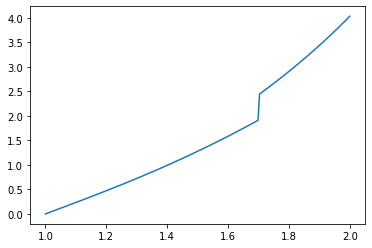

In [9]:
theta = 65 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,200,load))
plt.plot(check[:,0],check[:,1])

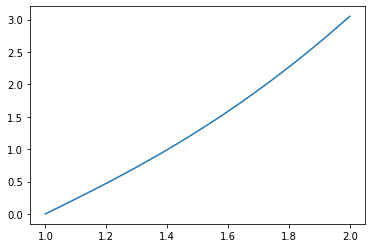

In [10]:
theta = 90 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

### Equibiaxial

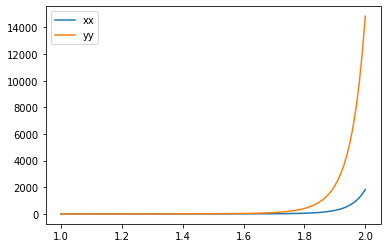

In [11]:
load = "equibiaxial"

c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0

theta = 0 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

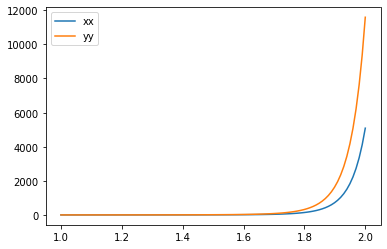

In [12]:
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

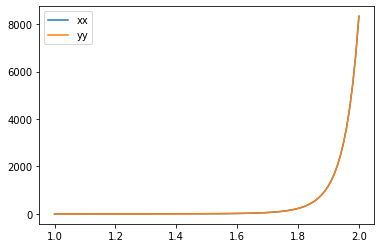

In [13]:
theta = 45 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

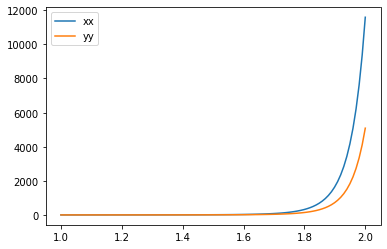

In [14]:
theta = 60 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

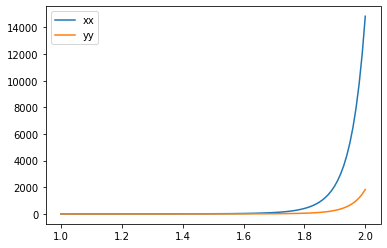

In [15]:
theta = 90 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

# Studying Neo-hookean parameter c

We will keep unitary parameters, a dispersion of 0.1 and an angle theta = 30°. c will take the values 0.01; 1.0; 100; 10000.

### Uniaxial

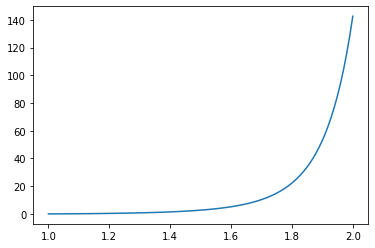

In [16]:
load = "uniaxial"

κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

c= 0.01 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

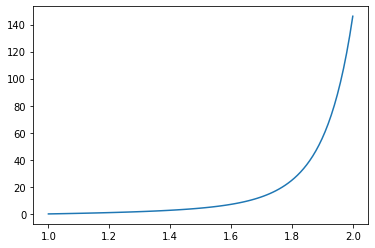

In [17]:
c= 1.0 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

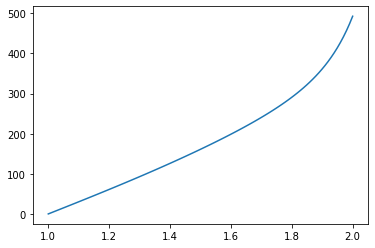

In [18]:
c= 100 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

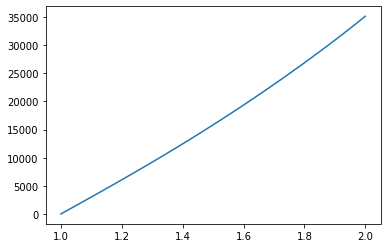

In [19]:
c= 10000 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

### Equibiaxial

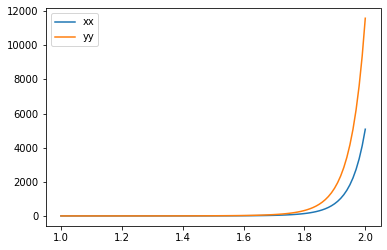

In [20]:
load = "equibiaxial"

κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

c= 0.01 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

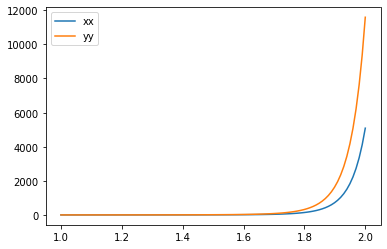

In [21]:
c= 1.0 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

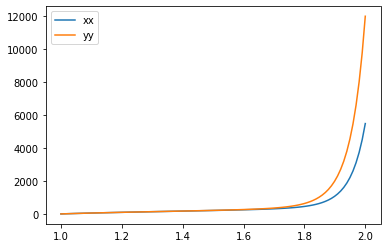

In [22]:
c= 100 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

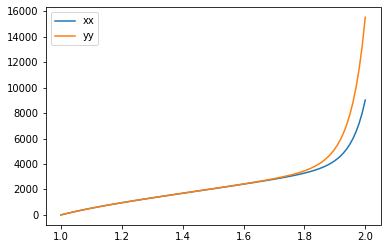

In [23]:
c= 1000 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

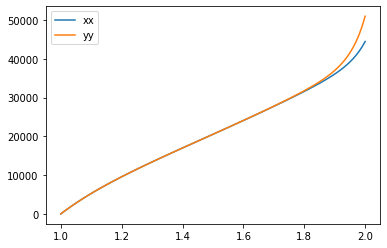

In [24]:
c= 10000 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

# Studying dispersion κ

We will keep unitary parameters and an angle theta = 30°. κ will take the values 0.0; 0.15; 0.3; 1/3.

### Uniaxial

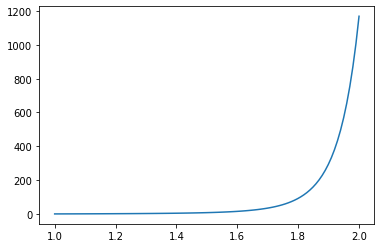

In [25]:
load = "uniaxial"

c= 1.0 # pressure units
k1 = 1.0 # pressure units
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

κ = 0

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

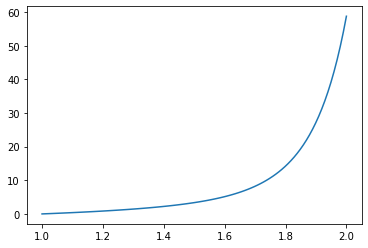

In [26]:
κ = 0.15

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

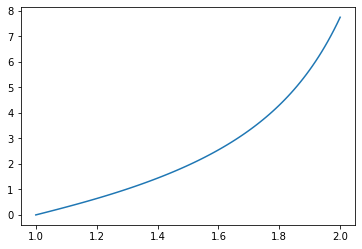

In [27]:
κ = 0.3

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

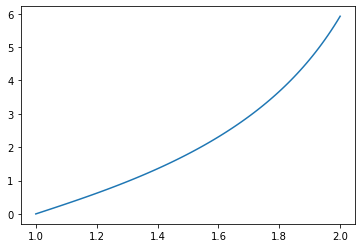

In [28]:
κ = 1/3

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

### Equibiaxial

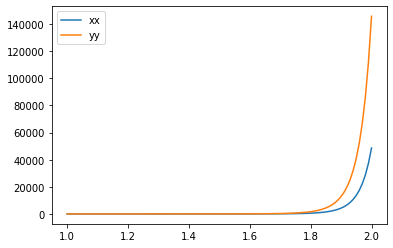

In [29]:
load = "equibiaxial"

c= 1.0 # pressure units
k1 = 1.0 # pressure units
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

κ = 0.0

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

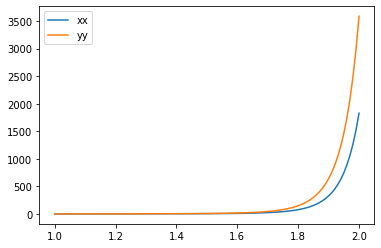

In [30]:
κ = 0.15

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

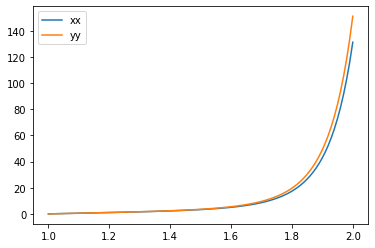

In [31]:
κ = 0.3

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

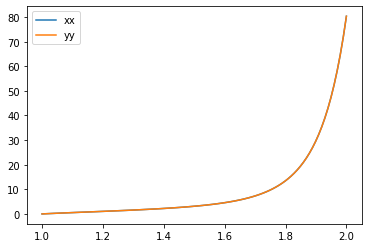

In [32]:
κ = 1/3

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

# Studying parameter k1

We will keep unitary parameters, a dispersion of 0.1 and an angle theta = 30°. k1 will take the values 0.01; 1.0; 100; 10000.

### Uniaxial

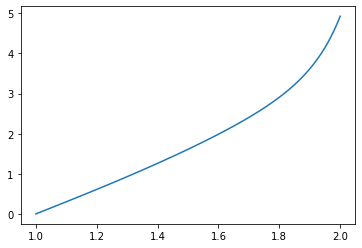

In [33]:
load = "uniaxial"

c= 1.0 # pressure units
κ = 0.1
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

k1 = 0.01 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

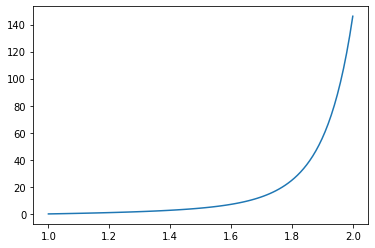

In [35]:
k1 = 1.0 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

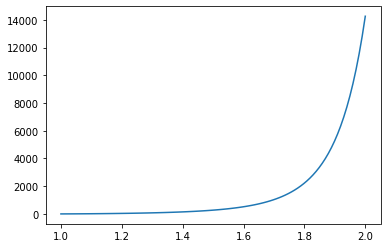

In [36]:
k1 = 100 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

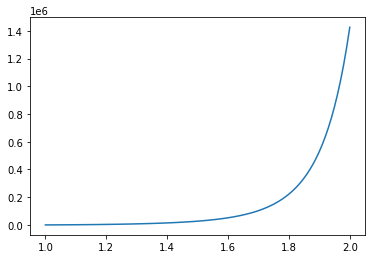

In [37]:
k1 = 10000 # pressure units

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

### Equibiaxial

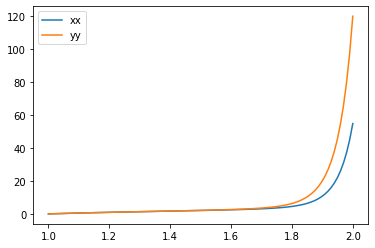

In [38]:
load = "equibiaxial"

c= 1.0 # pressure units
κ = 0.1
k2 = 1.0
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

k1 = 0.01 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

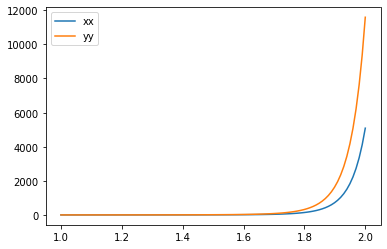

In [39]:
k1 = 1.0 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

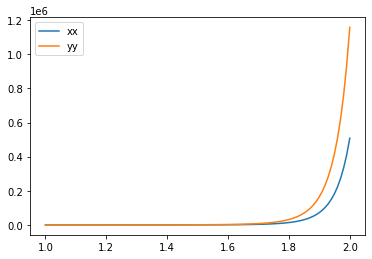

In [40]:
k1 = 100 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

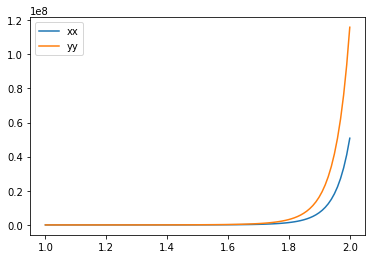

In [41]:
k1 = 10000 # pressure units

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

# Studying parameter k2

We will keep unitary parameters, a dispersion of 0.1 and an angle theta = 30°. k2 will take the values 0.01; 0.1; 0.5; 1.0; 5.0; 10.0; 100.0

### Uniaxial

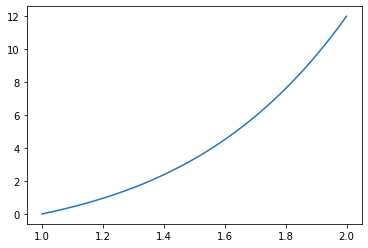

In [42]:
load = "uniaxial"

c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

k2 = 0.01

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

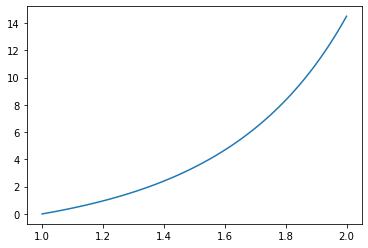

In [43]:
k2 = 0.1

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

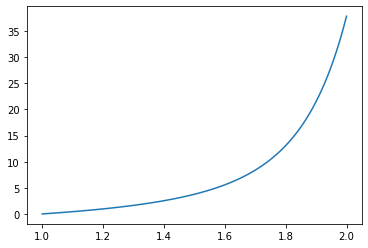

In [44]:
k2 = 0.5

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

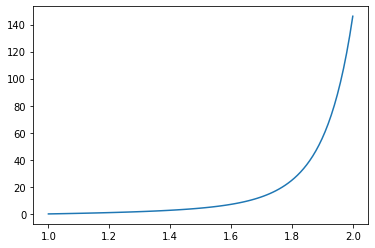

In [45]:
k2 = 1.0

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

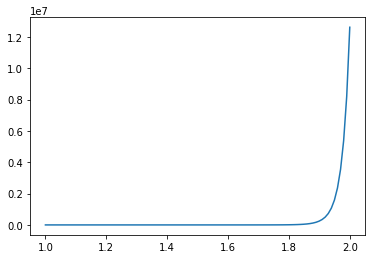

In [46]:
k2 = 5.0

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

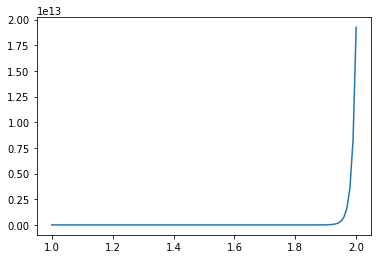

In [47]:
k2 = 10.0

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

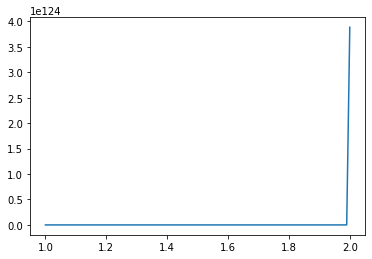

In [48]:
k2 = 100

params = [c, κ, k1, k2, a01]

check = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check[:,0],check[:,1])

### Equibiaxial

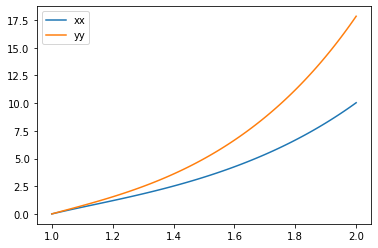

In [49]:
load = "equibiaxial"

c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
theta = 30 # degrees
a01 = [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

k2 = 0.01

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

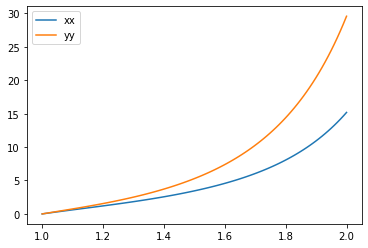

In [50]:
k2 = 0.1

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

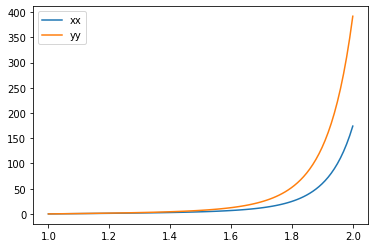

In [51]:
k2 = 0.5

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

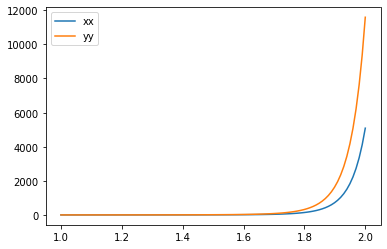

In [52]:
k2 = 1

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

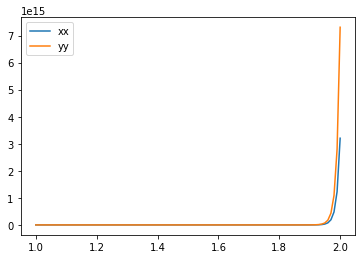

In [53]:
k2 = 5.0

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

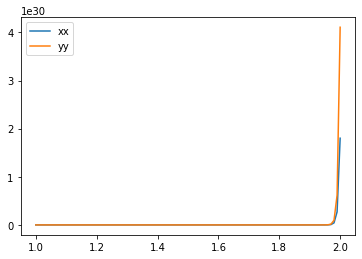

In [54]:
k2 = 10.0

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()

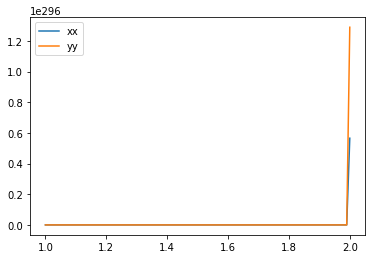

In [55]:
k2 = 100

params = [c, κ, k1, k2, a01]

[check_xx,check_yy] = np.array(get_curve(params,1.0,2.0,100,load))
plt.plot(check_xx[:,0],check_xx[:,1],label = "xx")
plt.plot(check_yy[:,0],check_yy[:,1], label = "yy")
plt.legend()